In [59]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from sklearn.preprocessing import MinMaxScaler

# Step 1: Import the data

In [61]:
df = pd.read_csv('Google_Stock_Price_Train-1.csv')
# We'll use the 'Open' price for prediction
timeseries = df[["Open"]].values.astype('float32')

# Step 2: Preprocess the data

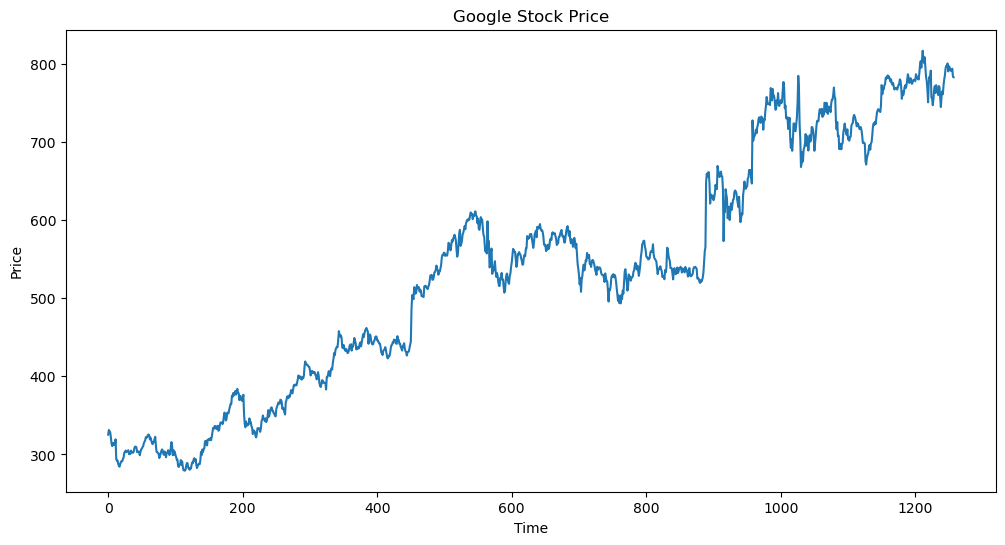

In [63]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
timeseries_scaled = scaler.fit_transform(timeseries)

# Visualize the data
plt.figure(figsize=(12,6))
plt.plot(timeseries)
plt.title('Google Stock Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

# Step 3: Split into 80% train 20% prediction

In [65]:
train_size = int(len(timeseries_scaled) * 0.8)
test_size = len(timeseries_scaled) - train_size
train, test = timeseries_scaled[:train_size], timeseries_scaled[train_size:]

## Transform a time series into a prediction dataset

In [67]:
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    Returns:
        Tensors X and y containing features and targets respectively
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+lookback]
        X.append(feature)
        y.append(target)
    
    # Convert lists to numpy arrays first
    X = np.array(X)
    y = np.array(y)
    
    # Convert numpy arrays to tensors
    return torch.from_numpy(X).float(), torch.from_numpy(y).float()

# Create sequences with lookback period of 60 days
lookback = 60
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)

# Reshape input data for LSTM [batch, sequence, feature]
X_train = X_train.reshape(-1, lookback, 1)
X_test = X_test.reshape(-1, lookback, 1)

print(f'Training shape: {X_train.shape}, {y_train.shape}')
print(f'Testing shape: {X_test.shape}, {y_test.shape}')

Training shape: torch.Size([946, 60, 1]), torch.Size([946, 1])
Testing shape: torch.Size([192, 60, 1]), torch.Size([192, 1])


# Step 4: Define and train the model

In [76]:
class StockLSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=2, batch_first=True, dropout=0.2)
        self.linear = nn.Linear(50, 1)
    
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x[:, -1, :])  # Take only the last output
        return x

In [78]:
model = StockLSTM()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=32)

# Training loop with 2000 epochs
n_epochs = 2000
train_losses = []
test_losses = []

print("Training started...")
for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    # Validation every 100 epochs to monitor progress
    if epoch % 100 == 0:
        model.eval()
        with torch.no_grad():
            # Train error
            y_pred = model(X_train)
            train_rmse = np.sqrt(loss_fn(y_pred, y_train).item())
            train_losses.append(train_rmse)
            
            # Test error
            y_pred = model(X_test)
            test_rmse = np.sqrt(loss_fn(y_pred, y_test).item())
            test_losses.append(test_rmse)
            
        print(f"Epoch {epoch}/{n_epochs}: train RMSE {train_rmse:.4f}, test RMSE {test_rmse:.4f}")

print("Training completed!")

Training started...
Epoch 0/2000: train RMSE 0.1944, test RMSE 0.4596
Epoch 100/2000: train RMSE 0.0184, test RMSE 0.0182
Epoch 200/2000: train RMSE 0.0161, test RMSE 0.0177
Epoch 300/2000: train RMSE 0.0161, test RMSE 0.0177
Epoch 400/2000: train RMSE 0.0159, test RMSE 0.0246
Epoch 500/2000: train RMSE 0.0160, test RMSE 0.0271
Epoch 600/2000: train RMSE 0.0152, test RMSE 0.0235
Epoch 700/2000: train RMSE 0.0155, test RMSE 0.0404
Epoch 800/2000: train RMSE 0.0147, test RMSE 0.0439
Epoch 900/2000: train RMSE 0.0142, test RMSE 0.0473
Epoch 1000/2000: train RMSE 0.0136, test RMSE 0.0432
Epoch 1100/2000: train RMSE 0.0132, test RMSE 0.0541
Epoch 1200/2000: train RMSE 0.0130, test RMSE 0.0474
Epoch 1300/2000: train RMSE 0.0123, test RMSE 0.0532
Epoch 1400/2000: train RMSE 0.0114, test RMSE 0.0614
Epoch 1500/2000: train RMSE 0.0112, test RMSE 0.0608
Epoch 1600/2000: train RMSE 0.0121, test RMSE 0.0511
Epoch 1700/2000: train RMSE 0.0105, test RMSE 0.0538
Epoch 1800/2000: train RMSE 0.0100, te

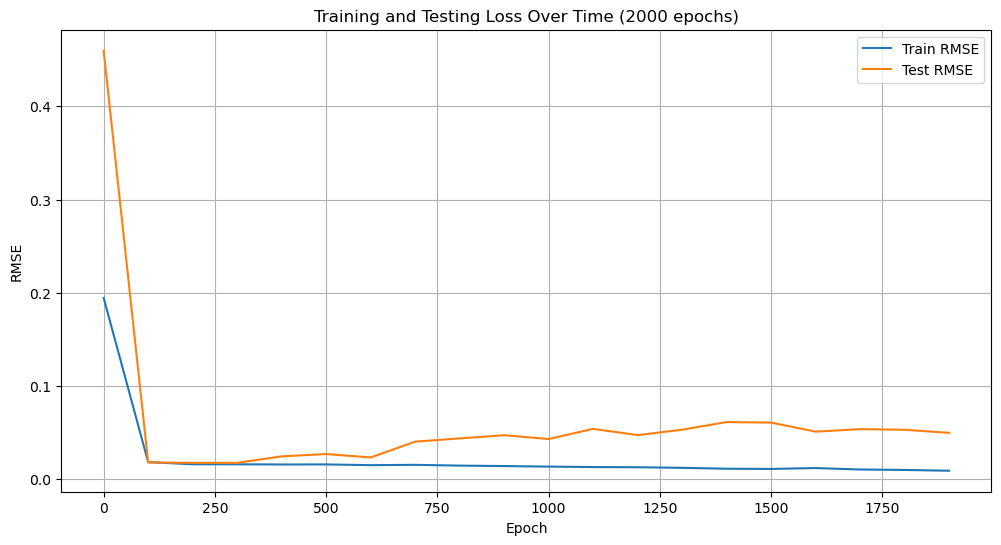

In [79]:
# Plot loss curves
plt.figure(figsize=(12,6))
plt.plot(range(0, n_epochs, 100), train_losses, label='Train RMSE')
plt.plot(range(0, n_epochs, 100), test_losses, label='Test RMSE')
plt.title('Training and Testing Loss Over Time (2000 epochs)')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()


## Generate predictions and calculate final metrics

In [80]:
model.eval()
with torch.no_grad():
    # Generate predictions
    train_predict = model(X_train).numpy()
    test_predict = model(X_test).numpy()
    
    # Inverse transform predictions
    train_predict = scaler.inverse_transform(train_predict)
    test_predict = scaler.inverse_transform(test_predict)
    y_train_orig = scaler.inverse_transform(y_train.numpy().reshape(-1, 1))
    y_test_orig = scaler.inverse_transform(y_test.numpy().reshape(-1, 1))

# Calculate final RMSE
train_rmse = np.sqrt(np.mean((train_predict - y_train_orig) ** 2))
test_rmse = np.sqrt(np.mean((test_predict - y_test_orig) ** 2))
print('\nFinal Results after 2000 epochs:')
print(f'Training RMSE: ${train_rmse:.2f}')
print(f'Testing RMSE: ${test_rmse:.2f}')


Final Results after 2000 epochs:
Training RMSE: $4.30
Testing RMSE: $28.76


## Plot the final predictions

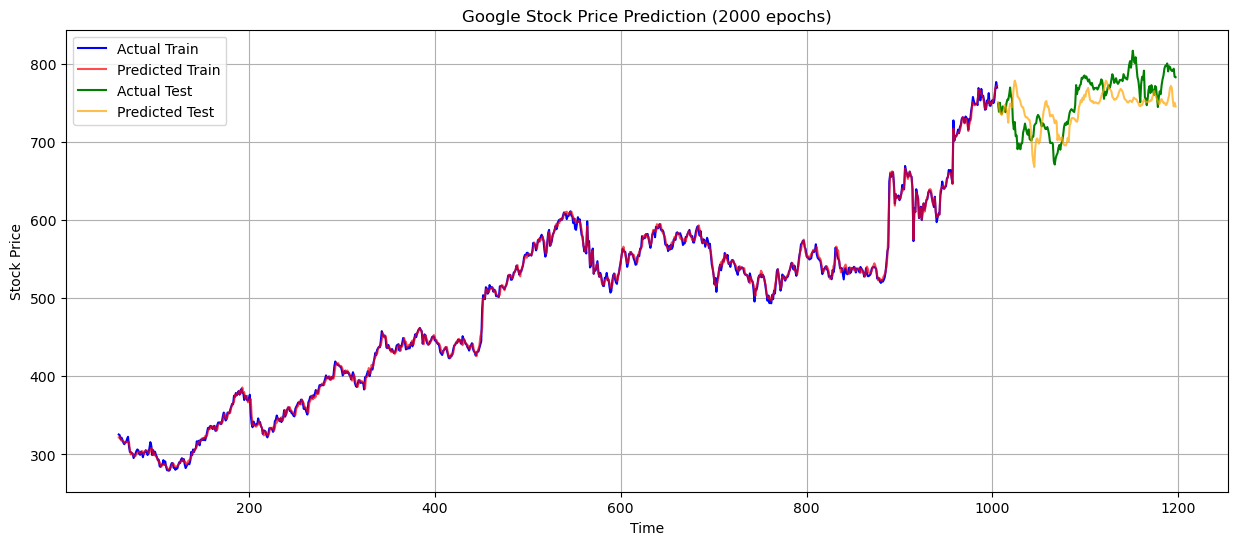

In [81]:
plt.figure(figsize=(15,6))
plt.plot(range(lookback, len(train_predict) + lookback), y_train_orig, 
         label='Actual Train', color='blue')
plt.plot(range(lookback, len(train_predict) + lookback), train_predict, 
         label='Predicted Train', color='red', alpha=0.7)
plt.plot(range(len(train_predict) + lookback, len(train_predict) + len(test_predict) + lookback), 
         y_test_orig, label='Actual Test', color='green')
plt.plot(range(len(train_predict) + lookback, len(train_predict) + len(test_predict) + lookback), 
         test_predict, label='Predicted Test', color='orange', alpha=0.7)
plt.title('Google Stock Price Prediction (2000 epochs)')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

# Step 5. Report on the results of your model

1. **Size of Training and Testing Data**:
- Training samples: 946 sequences, each of length 60 timesteps
- Testing samples: 192 sequences
- This is roughly an 80-20 split for the data

2. **Convergence from Loss Curve**:
- Initial train RMSE: 0.1944
- Initial test RMSE: 0.4596
- Final train RMSE: 0.0092 [normalized]
- Final test RMSE: 0.0499 [normalized]
- Final train RMSE: $4.30 [actual dollars]
- Final test RMSE: $28.76 [actual dollars]


3. **Training Behavior Analysis**:
- Rapid initial improvement: The model showed significant improvement in the first 100 epochs
- Best performance: Around epoch 100-200 (lowest combined train/test error)
- Overfitting indicators: After epoch 700, the test RMSE starts increasing while train RMSE continues to decrease
- The gap between training and testing error widens over time, indicating overfitting

4. **Performance of Prediction**
- Excellent in training prediction: RMSE $4.30
- Reasonable but less accurate in testing prediction: RMSE $28.76
- Model does a great job capturing the big picture, but its test set predictions are off by value.

5. **Visualization Analysis**:
- The training predictions, depicted by the blue and red lines, track very closely
- Test predictions, depicted by green and orange lines, are tracking the overall trend with much higher variance
- It seems the model is capturing the big movements in price while suppressing much of the volatility

6. **Areas for Improvement**:
1. Early stopping should be put into place around the 200-300 epoch mark to avoid overfitting
2. Increase regularization either by dropout or add L2 regularization
3. Use a less complex model
4. Feature engineering - more technical indicators, more relevant features
5. Other sequence lengths can be tried; currently using 60 days.

7. **Model Applicability**:
- Suitable for trend prediction
- Less reliable for exact price predictions
- Better at short-term predictions than long-term ones
- Should be used as part of a broader analytical system, rather than being used alone

8. **Recommendations**:
1. Stopping training earlier (around epoch 200) to prevent overfitting
2. Using ensemble methods to improve prediction stability
3. Adding more features beyond just the price data
4. Considering using bidirectional LSTM or attention mechanisms
5. Implementing proper risk management when using for actual trading